In [34]:
##############################################################################
#Introduction to Modeling in Gen
#---------------------------------------------------------------------
#https://www.gen.dev/intro-to-modeling/Introduction%20to%20Modeling%20in%20Gen
##############################################################################

using Gen
using PyPlot

import PyPlot.grid

In [35]:
@gen function line_model(xs::Vector{Float64})
    n = length(xs)
    
    # We begin by sampling a slope and intercept for the line.
    # Before we have seen the data, we don't know the values of
    # these parameters, so we treat them as random choices. The
    # distributions they are drawn from represent our prior beliefs
    # about the parameters: in this case, that neither the slope nor the
    # intercept will be more than a couple points away from 0.
    slope = @trace(normal(0, 1), :slope)
    intercept = @trace(normal(0, 2), :intercept)
    
    # Given the slope and intercept, we can sample y coordinates
    # for each of the x coordinates in our input vector.
    for (i, x) in enumerate(xs)
        @trace(normal(slope * x + intercept, 0.1), (:y, i))
    end
    
    # The return value of the model is often not particularly important,
    # Here, we simply return n, the number of points.
    return n
end;

function render_trace(trace; show_data=true)
    
    # Pull out xs from the trace
    xs = get_args(trace)[1]
    
    xmin = minimum(xs)
    xmax = maximum(xs)
    if show_data
        ys = [trace[(:y, i)] for i=1:length(xs)]
        
        # Plot the data set
        scatter(xs, ys, c="black")
    end
    
    # Pull out slope and intercept from the trace
    slope = trace[:slope]
    intercept = trace[:intercept]
    
    # Draw the line
    plot([xmin, xmax], slope *  [xmin, xmax] .+ intercept, color="black", alpha=0.5)
    ax = gca()
    ax[:set_xlim]((xmin, xmax))
    ax[:set_ylim]((xmin, xmax))
end;

function grid(renderer::Function, traces; ncols=6, nrows=3)
    figure(figsize=(16, 8))
    for (i, trace) in enumerate(traces)
        subplot(nrows, ncols, i)
        renderer(trace)
    end
end;

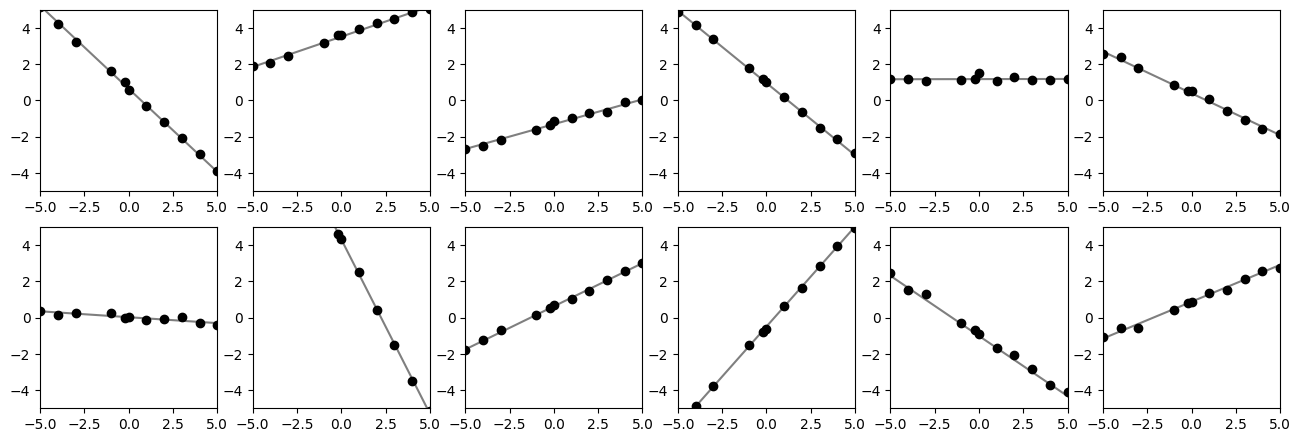

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = render_trace(::Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}; show_data::Bool) at In[35]:45
└ @ Main ./In[35]:45
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = render_trace(::Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}; show_data::Bool) at In[35]:46
└ @ Main ./In[35]:46


In [36]:
xs = [-5., -4., -3., -.2, -1., 0., 1., 2., 3., 4., 5.];

n = line_model(xs)

traces = [Gen.simulate(line_model, (xs,)) for _=1:12]
grid(render_trace, traces)

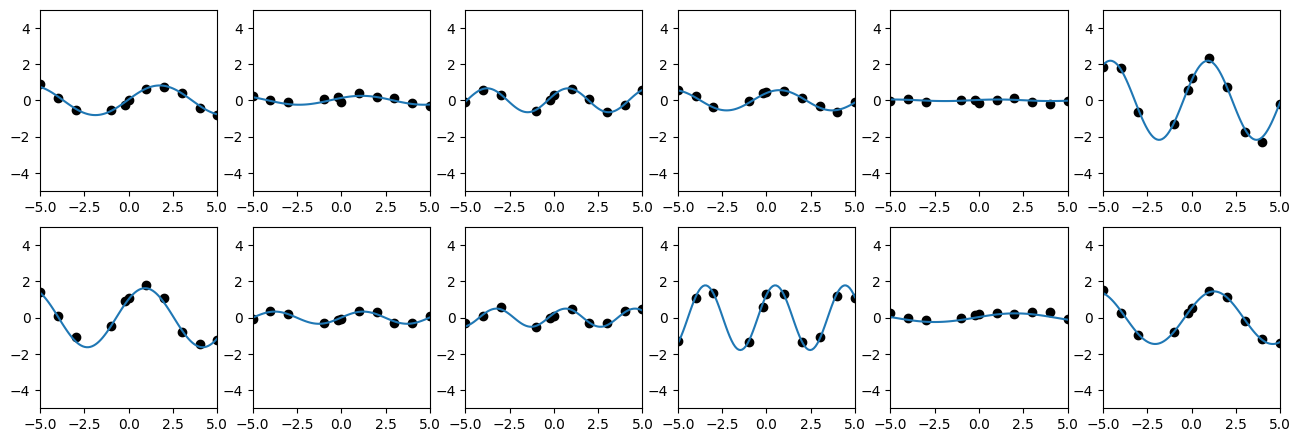

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = render_sine_trace(::Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}; show_data::Bool) at In[37]:37
└ @ Main ./In[37]:37
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = render_sine_trace(::Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}; show_data::Bool) at In[37]:38
└ @ Main ./In[37]:38


In [37]:
@gen function sin_model(xs::Vector{Float64})
    n = length(xs)
    
    #Sin Wave Function
    period = @trace(gamma(5, 1), :period)
    amplitude = @trace(gamma(1,1), :amplitude)
    phase = @trace(uniform(0,1), :phase)

    #Sample y coordinates for each x coordinate
    for (i, x) in enumerate(xs)
        mu = amplitude * sin(2 * pi * x / period + phase)
        @trace(normal(mu, 0.1), (:y, i))
    end
    
    return n
end;

traces = [Gen.simulate(sin_model, (xs,)) for _=1:12]

function render_sine_trace(trace; show_data=true)
    xs = get_args(trace)[1]
    xmin = minimum(xs)
    xmax = maximum(xs)
    if show_data
        ys = [trace[(:y, i)] for i=1:length(xs)]
        scatter(xs, ys, c="black")
    end
    
    phase = trace[:phase]
    period = trace[:period]
    amplitude = trace[:amplitude]
    
    test_points = collect(range(xmin, stop=xmax, length=100))
    plot(test_points, amplitude * sin.(2 * pi * test_points / period .+ phase))
    
    ax = gca()
    ax[:set_xlim]((xmin, xmax))
    ax[:set_ylim]((xmin, xmax))
end;

figure(figsize=(16, 8))
for (i, trace) in enumerate(traces)
    subplot(3, 6, i)
    render_sine_trace(trace)
end

In [38]:
##############################
#Inference
##############################
ys = [6.75003, 6.1568, 4.26414, 1.84894, 3.09686, 1.94026, 1.36411, -0.83959, -0.976, -1.93363, -2.91303];

function do_inference(model, xs, ys, amount_of_computation)
    
    # Create a choice map that maps model addresses (:y, i)
    # to observed values ys[i]. We leave :slope and :intercept
    # unconstrained, because we want them to be inferred.
    observations = Gen.choicemap()
    for (i, y) in enumerate(ys)
        observations[(:y, i)] = y
    end
    
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    (trace, _) = Gen.importance_resampling(model, (xs,), observations, amount_of_computation);
    return trace
end;

function overlay(renderer, traces; same_data=true, args...)
    renderer(traces[1], show_data=true, args...)
    for i=2:length(traces)
        renderer(traces[i], show_data=!same_data, args...)
    end
end;

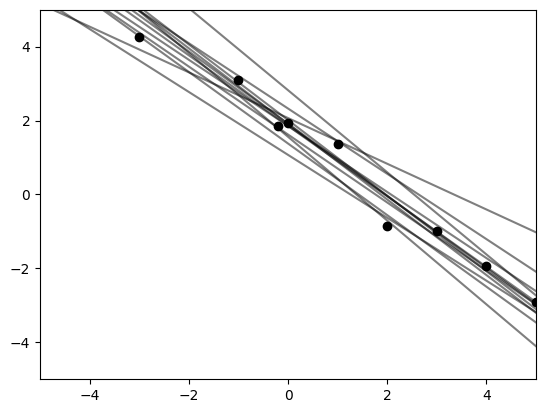

In [39]:
traces = [do_inference(line_model, xs, ys, 100) for _=1:12];
overlay(render_trace, traces)

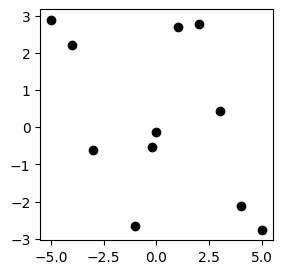

In [40]:
xs = [-5., -4., -3., -.2, -1., 0., 1., 2., 3., 4., 5.];
ys = [2.89, 2.22, -0.612, -0.522, -2.65, -0.133, 2.70, 2.77, 0.425, -2.11, -2.76];
figure(figsize=(3, 3));
scatter(xs, ys, color="black");

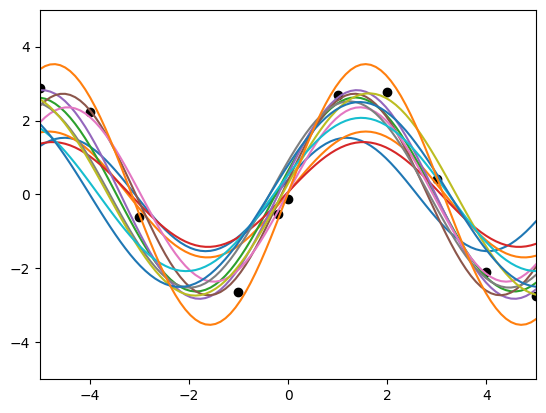

In [41]:
function sin_inference(model, xs, ys, amount_of_computation)
    
    # Create a choice map that maps model addresses (:y, i)
    # to observed values ys[i]. We leave :slope and :intercept
    # unconstrained, because we want them to be inferred.
    observations = Gen.choicemap()
    for (i, y) in enumerate(ys)
        observations[(:y, i)] = y
    end
    
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    (trace, _) = Gen.importance_resampling(model, (xs,), observations, amount_of_computation);
    return trace
end;

traces = [do_inference(sin_model, xs, ys, 100) for _=1:12];
overlay(render_sine_trace, traces)

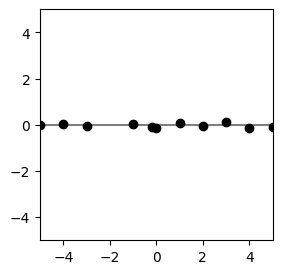

In [42]:
constraints = Gen.choicemap()
constraints[:slope] = 0.
constraints[:intercept] = 0.
(trace, _) = Gen.generate(line_model, (xs,), constraints)
figure(figsize=(3,3))
render_trace(trace);

In [43]:
function predict_new_data(model, trace, new_xs::Vector{Float64}, param_addrs)
    
    # Copy parameter values from the inferred trace (`trace`)
    # into a fresh set of constraints.
    constraints = Gen.choicemap()
    for addr in param_addrs
        constraints[addr] = trace[addr]
    end
    
    # Run the model with new x coordinates, and with parameters 
    # fixed to be the inferred values
    (new_trace, _) = Gen.generate(model, (new_xs,), constraints)
    
    # Pull out the y-values and return them
    ys = [new_trace[(:y, i)] for i=1:length(new_xs)]
    return ys
end;

function infer_and_predict(model, xs, ys, new_xs, param_addrs, num_traces, amount_of_computation)
    pred_ys = []
    for i=1:num_traces
        trace = do_inference(model, xs, ys, amount_of_computation)
        push!(pred_ys, predict_new_data(model, trace, new_xs, param_addrs))
    end
    pred_ys
end;

function plot_predictions(xs, ys, new_xs, pred_ys)
    scatter(xs, ys, color="red")
    for pred_ys_single in pred_ys
        scatter(new_xs, pred_ys_single, color="black", s=1, alpha=0.3)
    end
end;

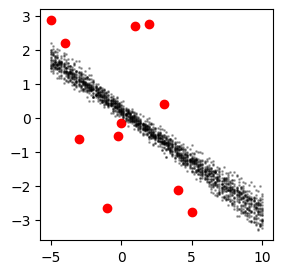

In [44]:
new_xs = collect(range(-5, stop=10, length=100));

pred_ys = infer_and_predict(line_model, xs, ys, new_xs, [:slope, :intercept], 20, 1000)
figure(figsize=(3,3))
plot_predictions(xs, ys, new_xs, pred_ys)

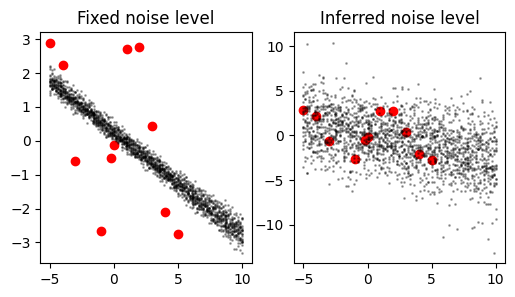

In [45]:
ys_noisy = [5.092, 4.781, 2.46815, 1.23047, 0.903318, 1.11819, 2.10808, 1.09198, 0.0203789, -2.05068, 2.66031];

@gen function line_model_2(xs::Vector{Float64})
    n = length(xs)
    slope = @trace(normal(0, 1), :slope)
    intercept = @trace(normal(0, 2), :intercept)
    noise = @trace(gamma(1, 1), :noise)
    for (i, x) in enumerate(xs)
        @trace(normal(slope * x + intercept, noise), (:y, i))
    end
    return nothing
end;

figure(figsize=(6,3))

pred_ys = infer_and_predict(line_model, xs, ys, new_xs, [:slope, :intercept], 20, 1000)
subplot(1, 2, 1)
title("Fixed noise level")
plot_predictions(xs, ys, new_xs, pred_ys)

pred_ys = infer_and_predict(line_model_2, xs, ys, new_xs, [:slope, :intercept, :noise], 20, 10000)
subplot(1, 2, 2)
title("Inferred noise level")
plot_predictions(xs, ys, new_xs, pred_ys)

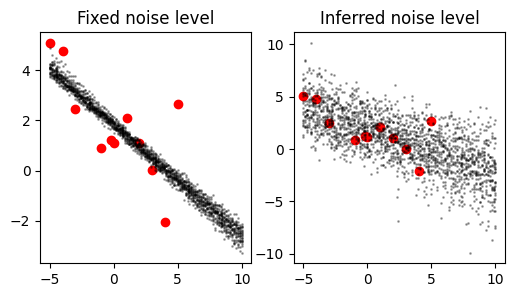

In [46]:
figure(figsize=(6,3))

pred_ys = infer_and_predict(line_model, xs, ys_noisy, new_xs, [:slope, :intercept], 20, 1000)
subplot(1, 2, 1)
title("Fixed noise level")
plot_predictions(xs, ys_noisy, new_xs, pred_ys)

pred_ys = infer_and_predict(line_model_2, xs, ys_noisy, new_xs, [:slope, :intercept, :noise], 20, 10000)
subplot(1, 2, 2)
title("Inferred noise level")
plot_predictions(xs, ys_noisy, new_xs, pred_ys)

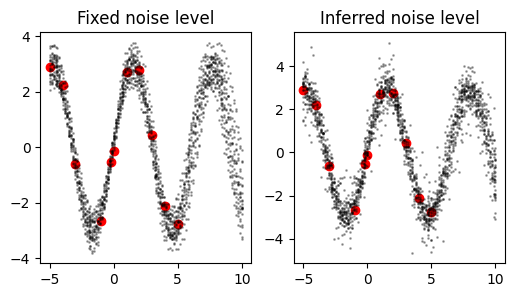

In [47]:
xs = [-5., -4., -3., -.2, -1., 0., 1., 2., 3., 4., 5.];
ysin = [2.89, 2.22, -0.612, -0.522, -2.65, -0.133, 2.70, 2.77, 0.425, -2.11, -2.76];

@gen function sin_model_2(xs::Vector{Float64})
    n = length(xs)
    
    #Sin Wave Function
    period = @trace(gamma(5, 1), :period)
    amplitude = @trace(gamma(1,1), :amplitude)
    phase = @trace(uniform(0,1), :phase)
    noise = @trace(gamma(1, 1), :noise)

    #Sample y coordinates for each x coordinate
    for (i, x) in enumerate(xs)
        mu = amplitude * sin(2 * pi * x / period + phase)
        @trace(normal(mu, noise), (:y, i))
    end
    
    return n
end;

figure(figsize=(6,3))

pred_ys = infer_and_predict(sin_model, xs, ysin, new_xs, [:phase, :period, :amplitude], 20, 1000)
subplot(1, 2, 1)
title("Fixed noise level")
plot_predictions(xs, ysin, new_xs, pred_ys)

pred_ys = infer_and_predict(sin_model_2, xs, ysin, new_xs, [:phase, :period, :amplitude, :noise], 20, 10000)
subplot(1, 2, 2)
title("Inferred noise level")
plot_predictions(xs, ysin, new_xs, pred_ys)

In [48]:
@gen function combined_model(xs::Vector{Float64})
    if @trace(bernoulli(0.5), :is_line)
        @trace(line_model_2(xs))
    else
        @trace(sin_model_2(xs))
    end
end;

function render_combined(trace; show_data=true)
    if trace[:is_line]
        render_trace(trace, show_data=show_data)
    else
        render_sine_trace(trace, show_data=show_data)
    end
end;

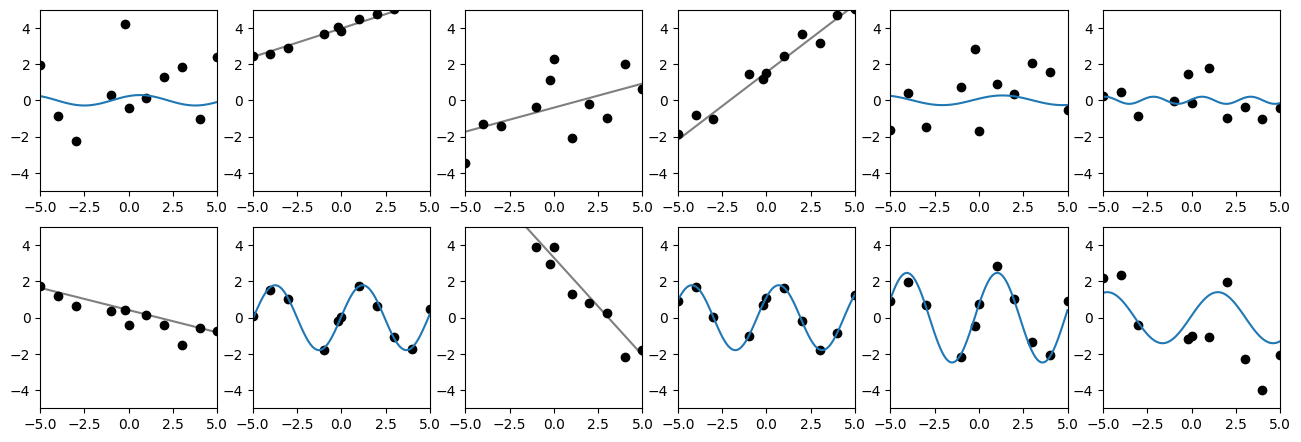

In [49]:
traces = [Gen.simulate(combined_model, (xs,)) for _=1:12];
grid(render_combined, traces)

In [50]:
figure(figsize=(6,3))
subplot(1, 2, 1)
traces = [do_inference(combined_model, xs, ys, 1000) for _=1:10];
overlay(render_combined, traces)
subplot(1, 2, 2)
traces = [do_inference(combined_model, xs, ys_sine, 1000) for _=1:10];
overlay(render_combined, traces)

UndefVarError: UndefVarError: ys_sine not defined

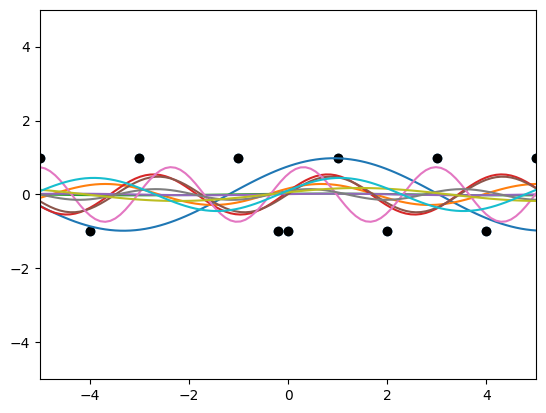

In [51]:
ynew = [1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1]
scatter(xs, ynew)


traces = [do_inference(combined_model, xs, ynew, 100) for _=1:10];
overlay(render_combined, traces)

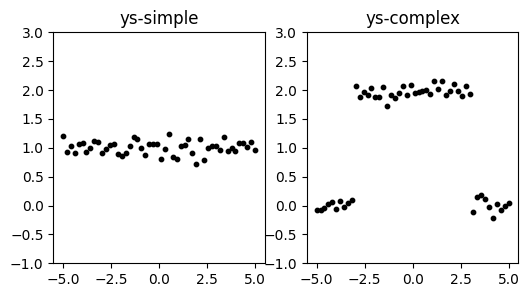

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[52]:18
└ @ Core In[52]:18
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[52]:23
└ @ Core In[52]:23


50-element Array{Float64,1}:
 -0.08
 -0.07
 -0.04
  0.03
  0.05
 -0.06
  0.08
 -0.02
  0.04
  0.09
  2.07
  1.88
  1.96
  ⋮
  2.07
  1.93
 -0.11
  0.15
  0.17
  0.12
 -0.02
 -0.22
  0.02
 -0.08
 -0.0
  0.04

In [52]:
##############################
#Non-Parametrics
##############################

using Gen
using PyPlot

#Declare 2 new datasets
xs_dense = collect(range(-5, stop=5, length=50))
ys_simple = fill(1., length(xs_dense)) .+ randn(length(xs_dense)) * 0.1
ys_complex = [Int(floor(abs(x/3))) % 2 == 0 ? 2 : 0 for x in xs_dense] .+ randn(length(xs_dense)) * 0.1;

figure(figsize=(6,3))

subplot(1, 2, 1)
title("ys-simple")
scatter(xs_dense, ys_simple, color="black", s=10)
gca()[:set_ylim]((-1, 3))

subplot(1, 2, 2)
title("ys-complex")
scatter(xs_dense, ys_complex, color="black", s=10)
gca()[:set_ylim]((-1, 3))

round.(ys_complex; digits=2)

In [53]:
#Goal: Declare a model that does not know how many changepoints there are

#Struct is like a python "Class"
#We have an upper and lower value for each interval
struct Interval
    l::Float64
    u::Float64
end

abstract type Node end
    
struct InternalNode <: Node
    left::Node
    right::Node
    interval::Interval
end

struct LeafNode <: Node
    value::Float64
    interval::Interval
end

#This function generates segments for "proposals"
@gen function generate_segments(l::Float64, u::Float64)
    interval = Interval(l, u)
    if @trace(bernoulli(0.7), :isleaf)
        value = @trace(normal(0, 1), :value)
        return LeafNode(value, interval)
    else
        frac = @trace(beta(2, 2), :frac)
        mid  = l + (u - l) * frac
        left = @trace(generate_segments(l, mid), :left)
        right = @trace(generate_segments(mid, u), :right)
        return InternalNode(left, right, interval)
    end
end;

#For trace visualization
function render_node(node::LeafNode)
    plot([node.interval.l, node.interval.u], [node.value, node.value])
end

function render_node(node::InternalNode)
    render_node(node.left)
    render_node(node.right)
end;

function render_segments_trace(trace)
    node = get_retval(trace)
    render_node(node)
    ax = gca()
    ax[:set_xlim]((0, 1))
    ax[:set_ylim]((-3, 3))
end;

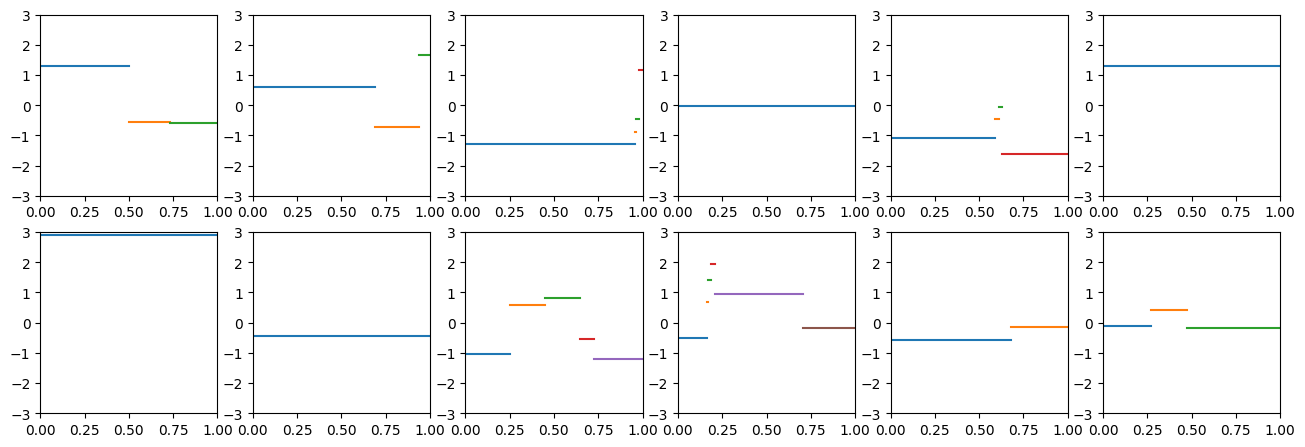

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = render_segments_trace(::Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}) at In[53]:52
└ @ Main ./In[53]:52
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = render_segments_trace(::Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}) at In[53]:53
└ @ Main ./In[53]:53


In [54]:
#Run segment simulation and plot samples
traces = [Gen.simulate(generate_segments, (0., 1.)) for i=1:12]
grid(render_segments_trace, traces)

In [55]:
# get_value_at searches a binary tree for
# the leaf node containing some value.
function get_value_at(x::Float64, node::LeafNode)
    @assert x >= node.interval.l && x <= node.interval.u
    return node.value
end

function get_value_at(x::Float64, node::InternalNode)
    @assert x >= node.interval.l && x <= node.interval.u
    if x <= node.left.interval.u
        get_value_at(x, node.left)
    else
        get_value_at(x, node.right)
    end
end

# Out full model
@gen function changepoint_model(xs::Vector{Float64})
    node = @trace(generate_segments(minimum(xs), maximum(xs)), :tree)
    noise = @trace(gamma(1, 1), :noise)
    for (i, x) in enumerate(xs)
        @trace(normal(get_value_at(x, node), noise), (:y, i))
    end
    return node
end;

function render_changepoint_model_trace(trace; show_data=true)
    xs = Gen.get_args(trace)[1]
    node = Gen.get_retval(trace)
    render_node(node)
    if show_data
        ys = [trace[(:y, i)] for i=1:length(xs)]
        scatter(xs, ys, c="black")
    end
    ax = gca()
    ax[:set_xlim]((minimum(xs), maximum(xs)))
    ax[:set_ylim]((-3, 3))
end;

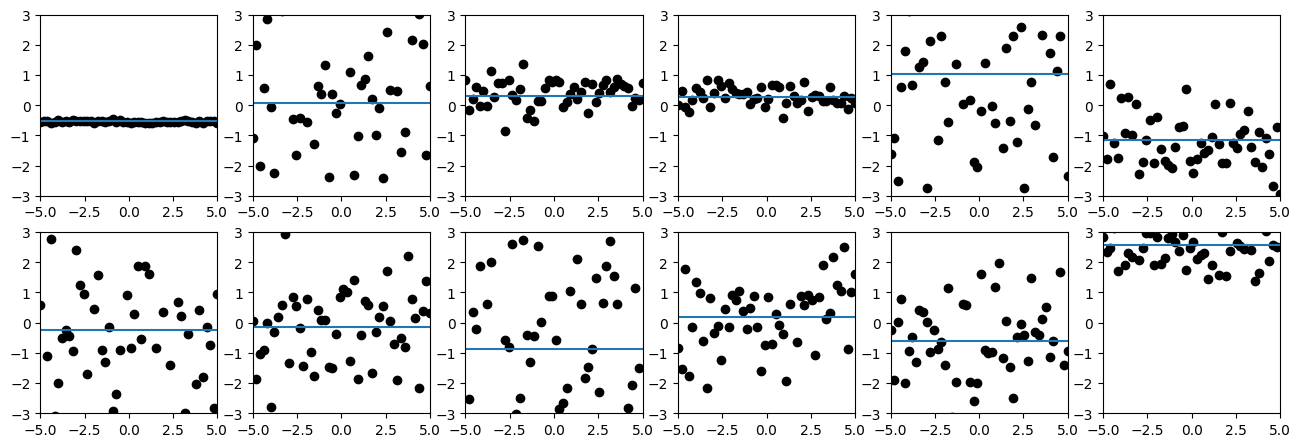

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = render_changepoint_model_trace(::Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}; show_data::Bool) at In[55]:36
└ @ Main ./In[55]:36
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = render_changepoint_model_trace(::Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}; show_data::Bool) at In[55]:37
└ @ Main ./In[55]:37


In [56]:
traces = [Gen.simulate(changepoint_model, (xs_dense,)) for i=1:12]
grid(render_changepoint_model_trace, traces)

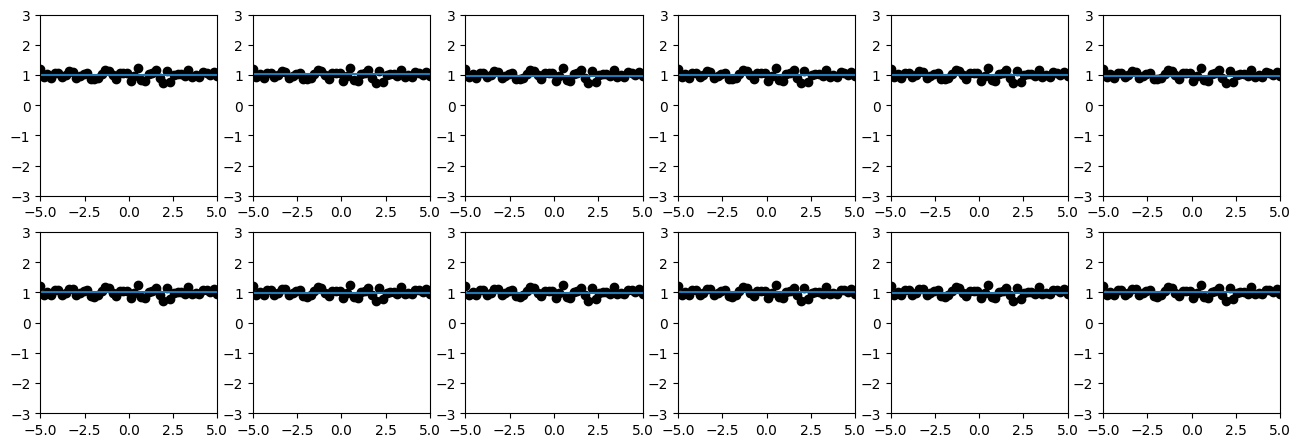

In [57]:
#Simple dataset inference
traces = [do_inference(changepoint_model, xs_dense, ys_simple, 10000) for _=1:12];
grid(render_changepoint_model_trace, traces)

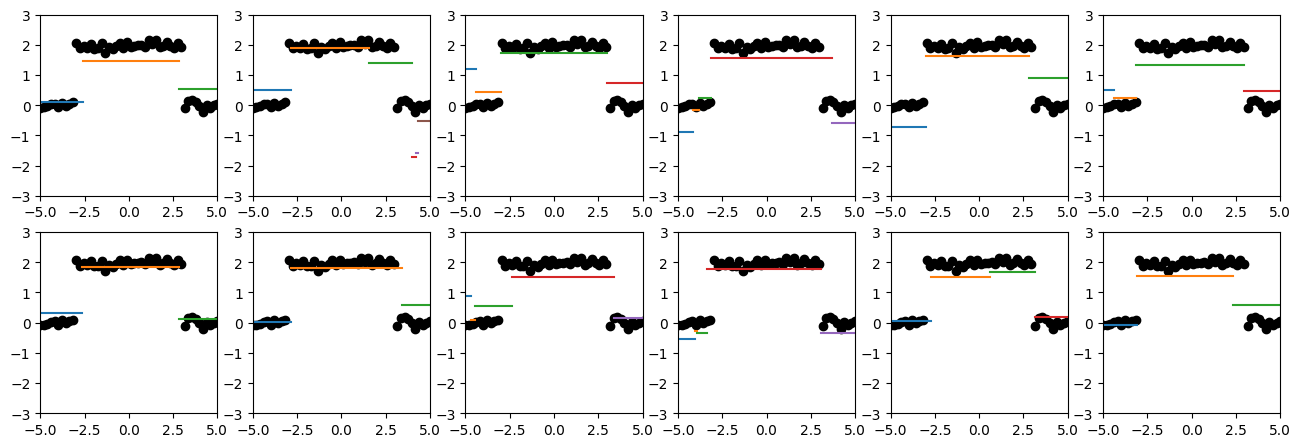

In [58]:
#Complex dataset inference
traces = [do_inference(changepoint_model, xs_dense, ys_complex, 100000) for _=1:12];
grid(render_changepoint_model_trace, traces)

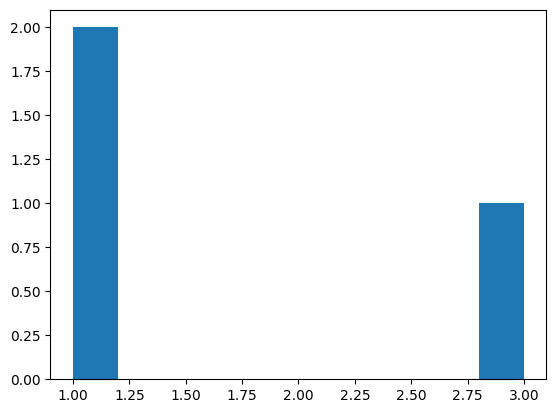

Any[1, 1, 3]


([2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4000000000000004, 2.6, 2.8, 3.0], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x7ff4007e2430>, PyObject <matplotlib.patches.Rectangle object at 0x7ff4007e2280>, PyObject <matplotlib.patches.Rectangle object at 0x7ff400cae760>, PyObject <matplotlib.patches.Rectangle object at 0x7ff400cae340>, PyObject <matplotlib.patches.Rectangle object at 0x7ff400787160>, PyObject <matplotlib.patches.Rectangle object at 0x7ff400787a30>, PyObject <matplotlib.patches.Rectangle object at 0x7ff400787f40>, PyObject <matplotlib.patches.Rectangle object at 0x7ff4007876d0>, PyObject <matplotlib.patches.Rectangle object at 0x7ff400787d60>, PyObject <matplotlib.patches.Rectangle object at 0x7ff400cb8b20>])

In [74]:
#Exercise: Write a function that takes a data set of x- and y-coordinates and plots the histogram
#of the probability distribution on the number of changepoints. 
#Show the results for the ys_simple and ys_complex data sets.
#Hint: The return value of changepoint_model is the tree of Node values. Walk this tree.
##################################################################################################

function summary(xs::Vector{Float64}, ys::Vector{Float64}, model, num_traces::Int)
    counts = []
    traces = [do_inference(changepoint_model, xs, ys, 100000) for _=1:num_traces];
    for trace in traces
        tree = get_retval(trace)
        count = 0
        while typeof(tree) == InternalNode
            count += 1
            tree = tree.right
        end
        push!(counts, count)
    end
    return counts
end;

counts = summary(xs_dense, ys_complex, changepoint_model, 3)
println(counts)
hist(counts)


│
├── (:y, 22) : 1.9555686413280542
│
├── (:y, 20) : 1.9144397633982955
│
├── (:y, 37) : 1.9755741733293335
│
├── (:y, 3) : -0.037488551654901905
│
├── (:y, 6) : -0.060620178738246135
│
├── (:y, 29) : 1.9953060625872263
│
├── (:y, 33) : 2.1528275227453655
│
├── (:y, 46) : -0.2230310631394099
│
├── :noise : 0.7452518949827615
│
├── (:y, 36) : 2.098035331878954
│
├── (:y, 42) : 0.14761153126104665
│
├── (:y, 25) : 2.0865822505489886
│
├── (:y, 48) : -0.0826245095909991
│
├── (:y, 18) : 2.0481322520949874
│
├── (:y, 10) : 0.09344059217192237
│
├── (:y, 1) : -0.07799425877130993
│
├── (:y, 5) : 0.053207952436647145
│
├── (:y, 34) : 1.9168626190842926
│
├── (:y, 16) : 1.8793974949110044
│
├── (:y, 45) : -0.023440704590034868
│
├── (:y, 30) : 1.9301140235339818
│
├── (:y, 24) : 1.9105267629854361
│
├── (:y, 8) : -0.023807552811985613
│
├── (:y, 40) : 1.9300220973780005
│
├── (:y, 15) : 2.037918944265265
│
├── (:y, 14) : 1.910612015513663
│
├── (:y, 2) : -0.07280875676733344
│
├── (:y, 12) : 

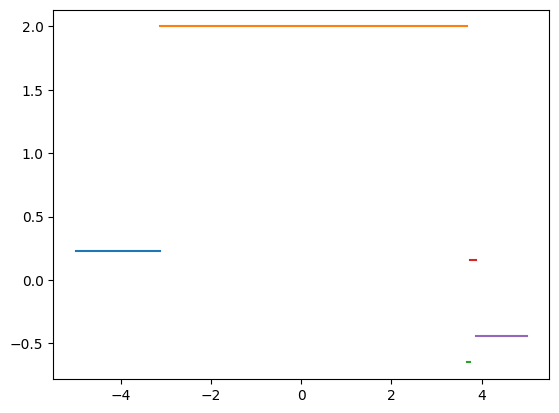

3


In [97]:
trace = do_inference(changepoint_model, xs_dense, ys_complex, 100000)
choice = get_choices(trace)
display(choice)
z = get_retval(trace)
render_node(z)
count = 0
    while typeof(z) == InternalNode
        count += 1
        z = z.right
    end
println(count)